<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/case_study_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Intent Detection: Case Study

Let’s suppose that we’re trying to build a text-based assistant for our company’s call center so
that customers can request the balance of their account or make bookings without needing to
speak with a human agent. In order to understand the goals of a customer, our assistant will
need to be able to classify a wide variety of natural language text into a set of predefined
actions or intents.

For example, a customer may send a message about an upcoming trip:

```txt
Hey, I’d like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van
```

and our intent classifier could automatically categorize this as a Car Rental intent, which then triggers an action and response.

To be robust in a production environment, our classifier will
also need to be able to handle out-of-scope queries.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/1.png?raw=1' width='600'/>

In the third case, the text-assistant
has been trained to detect out-of-scope queries (usually labelled as a separate class) and informs the customer about which topics they can respond to.

As a baseline we’ve fine-tuned a BERT-base model that achieves around `94%` accuracy on the
`CLINC150` dataset. This dataset includes `22,500` in-scope queries across `150` intents and `10`
domains like banking and travel, and also includes `1,200` out-of-scope queries that belong to an
oos intent class. In practice we would also gather our own in-house dataset, but using public
data is a great way to iterate quickly and generate preliminary results.



##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [33]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline)
from datasets import load_dataset, load_metric

import torch

from pathlib import Path
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now, let’s download our fine-tuned model from the Hugging Face Hub and wrap it in a pipeline for text classification:

In [ ]:
# molde path has changed: https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
bert_model = (AutoModelForSequenceClassification.from_pretrained(bert_ckpt).to("cpu"))

bert_pipeline = TextClassificationPipeline(model=bert_model, tokenizer=bert_tokenizer)

Here we’ve set the model’s device to cpu since our text-assistant will need to operate in an
environment where queries are processed and responded to in real-time.

Now that we have a pipeline, we can pass a query to get the predicted intent and confidence
score from the model:

In [4]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""

bert_pipeline(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

Great, the `car_rental` intent makes sense so let’s now look at creating a benchmark that we
can use to evaluate the performance of our baseline model.

##Performance Benchmark

Like any other machine learning model, deploying Transformers in production environments involves a trade-off among several constraints, the most common being:

- **Model performance**
  - How well does our model perform on a well-crafted test set that reflects production data?
- **Latency**
  - How fast can our model deliver predictions?
- **Memory**
  - How can we deploy billion-parameter models like GPT-2 or T5 that require gigabytes of disk storage and RAM?

Failing to address these constraints can have a negative impact on the user experience of your
application, or more commonly, lead to ballooning costs from running expensive cloud servers
that may only need to handle a few requests.

To explore how each of the these constraints can
be optimized with various compression techniques, let’s begin by creating a simple benchmark
that measures each quantity for a given pipeline and test set.

In [5]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline") -> None:
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    pass

  def compute_size(self):
    pass

  def time_pipeline(self):
    pass

  # We’ll use the run_benchmark function to collect all the metrics in a dictionary, with keys given by optim_type.
  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

First we need some data to test on, so let’s download the CLINC150 dataset that was used to finetune our baseline model. 

We can get the dataset from the Hub with the Datasets library as follows:

In [8]:
clinc = load_dataset("clinc_oos", "plus")
clinc

Reusing dataset clinc_oos (/root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

Each example in the CLINC150 dataset consists of a query in the text column and its corresponding intent. 

We’ll use the test set to benchmark our models, so let’s take a look at one
of the dataset’s examples:

In [9]:
clinc["test"][42]

{'intent': 133, 'text': 'transfer $100 from my checking to saving account'}

The intents are provided as IDs, but we can easily get the mapping to strings (and vice versa)
by accessing the `Dataset.features` attribute:

In [10]:
intents = clinc["test"].features["intent"]
intents.int2str(clinc["test"][42]["intent"])

'transfer'

###Exploring Class distribution

Now that we have a basic understanding of the contents in the CLINC150 dataset, let’s check it class distribution.

In [12]:
clinc.set_format(type="pandas")

df = clinc["train"][:]
df.head()

,text,intent
0,what expression would i use to say i love you ...,61
1,can you tell me how to say 'i do not speak muc...,61
2,"what is the equivalent of, 'life is good' in f...",61
3,"tell me how to say, 'it is a beautiful morning...",61
4,"if i were mongolian, how would i say that i am...",61


In [13]:
def label_int2str(row, split):
  return clinc[split].features["intent"].int2str(row)

In [15]:
df["label_name"] = df["intent"].apply(label_int2str, split="train")
df.head()

,text,intent,label_name
0,what expression would i use to say i love you ...,61,translate
1,can you tell me how to say 'i do not speak muc...,61,translate
2,"what is the equivalent of, 'life is good' in f...",61,translate
3,"tell me how to say, 'it is a beautiful morning...",61,translate
4,"if i were mongolian, how would i say that i am...",61,translate


In [20]:
df["label_name"].value_counts(ascending=True)

routing                   100
share_location            100
make_call                 100
restaurant_reviews        100
time                      100
                         ... 
cancel                    100
measurement_conversion    100
find_phone                100
freeze_account            100
oos                       250
Name: label_name, Length: 151, dtype: int64

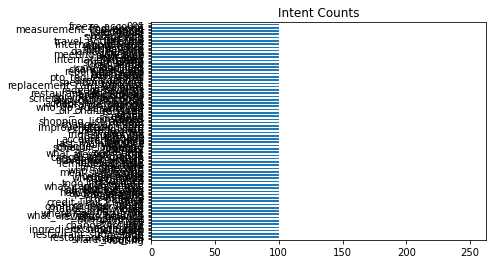

In [21]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Intent Counts");

In [22]:
# reset back to original format
clinc.reset_format()

###Updating Benchmark statistics

Since the dataset is balanced across the intent
classes, we’ll use accuracy as our metric which we can load from Datasets.

let’s implement the compute_accuracy function:

In [24]:
accuracy_score = load_metric("accuracy")
accuracy_score

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

The metric’s description tells us that we need to provide the predictions and references (i.e. the ground truth labels) as integers, so we can use the pipeline to extract the predictions from the
text field and then use the `ClassLabel.str2int` function to map the prediction to its corresponding ID.

So we need to collect all the predictions and labels in lists before
returning the accuracy on the dataset. 

Let’s also add it to our PerformanceBenchmark class:

In [26]:
def compute_accuracy(self):
  preds, labels = [], []
  for example in self.dataset:
    pred = self.pipeline(example["text"])[0]["label"]
    label = example["intent"]
    preds.append(intents.str2int(pred))
    labels.append(label)
  accuracy = accuracy_score.compute(predictions=preds, references=labels)
  print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
  return accuracy

# now update compute_accuracy method of PerformanceBenchmark class
PerformanceBenchmark.compute_accuracy = compute_accuracy

Next, let’s compute the size of our model by using the `torch.save` function from PyTorch to serialize the model to disk.In PyTorch,
the recommended way to save a model is by using its `state_dict`, which is a Python dictionary that maps each layer in a model to its learnable parameters (i.e. weights and biases).

Let’s see what is stored in the `state_dict` of our baseline model:

In [29]:
list(bert_pipeline.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

We can clearly see that each key-value pair corresponds to a specific layer and tensor in BERT.

We can then use the Path.stat function from Python’s `pathlib` module to get information about the underlying files. In particular `Path(PATH).stat().st_size` will give us the model size in bytes, so let’s put this all together in the `compute_size` function and add it to PerformanceBenchmark:

In [32]:
def compute_size(self):
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  # Calculate size in megabytes
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  # Delete temporary file
  tmp_path.unlink()
  print(f"Model size (MB) - {size_mb:.2f}")
  return {"size_mb": size_mb}

# now update compute_size method of PerformanceBenchmark class
PerformanceBenchmark.compute_size = compute_size

Finally let’s implement the `time_pipeline` function so that we can time the median latency
per query. For this application, latency refers to the time it takes to feed a text query to the
pipeline and return the predicted intent from the model.

Under the hood, the pipeline also
tokenizes the text but this is around 1,000 times faster than generating the predictions and thus
adds a negligible contribution to the overall latency.

A simple way to measure the time of a
code snippet is to use the `perf_counter` function from Python’s `time` module. This function has a better time resolution than the `time.time` function and so is well suited for getting precise results.

We can use `perf_counter` to time our `pipeline` by passing our test query and calculating the
time difference in milliseconds between the start and end:

In [34]:
for _ in range(3):
  start_time = perf_counter()
  _ = bert_pipeline(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 134.675
Latency (ms) - 122.182
Latency (ms) - 126.916


So instead,
we’ll collect the latencies over many runs and then use the resulting distribution to calculate the
mean and standard deviation, which will give us an idea about the spread in values. 

The following code does what we need and includes a phase to warm-up the CPU before performing the actual timed run:

In [35]:
def time_pipeline(self, query="What is the pin number for my account?"):
  latencies = []
  # Warmup
  for _ in range(10):
    _ = self.pipeline(query)
  # Timed run
  for _ in range(100):
    start_time = perf_counter()
    _ = bert_pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  # Compute run statistics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies)
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

# now update time_pipeline method of PerformanceBenchmark class
PerformanceBenchmark.time_pipeline = time_pipeline

###Benchmarking Our Baseline Model

Now that our `PerformanceBenchmark` is complete, let’s give it a spin! For the baseline
model we just need to pass the pipeline and dataset we wish to perform the benchmark on, and
we’ll collect the results in the `perf_metrics` dictionary to keep track of each model’s
performance:

In [36]:
pb = PerformanceBenchmark(bert_pipeline, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 75.03 +\- 3.96
Accuracy on test set - 0.867


Once we have determined the best performing model we can then explore different backends to reduce the absolute latency if needed.

Now that we have a reference point, let’s look at our first compression technique: **knowledge distillation**.

##Knowledge Distillation for Models Smaller